In [31]:
import sys
sys.path.append('..')
import fit_field_line_null
reload(fit_field_line_null)
from fit_field_line_null import find_field_null
import numpy as np

from write_to_vtk.read_unstructured_vtk import read_unstructured_vtk
from write_to_vtk import structured_3d_vtk as struc_3d

from scipy import ndimage

from centroid_fitting import gyration_path
reload(gyration_path)
gyration_path = gyration_path.gyration_path

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as axisartist
import matplotlib.patches as patches

In [22]:
def get_interpolations(time_point):
    in_dir = ('../../output/filtered_unstructured_measurements/' + 
              '2017-04-17-16-44' + '/')
    in_file = '_filtered_unstructured_'

    centroids = []


    bxby_extents = {0: [-0.027, 0.025, -0.057, 0.040, 0.249, 0.416],
                    1: [-0.027, 0.027, -0.073, 0.041, 0.249, 0.416],
                    2: [-0.047, 0.031, -0.021, 0.028, 0.249, 0.416],
                    3: [-0.061, 0.031, -0.026, 0.03,  0.249, 0.416]}
    bz_extents = {0: [-0.027, 0.025, -0.06, 0.041, 0.249, 0.416],
                  1: [-0.27, 0.027, -0.076, 0.041, 0.249, 0.416],
                  2: [-0.044, 0.031, -0.021, 0.03, 0.249, 0.416],
                  3: [-0.072, 0.031, -0.026, 0.03, 0.249, 0.416]}

    bxby_extent = bxby_extents[0]
    bz_extent = bz_extents[0]



    time_str = str(time_point).zfill(4)
    bx_points, bx_values = read_unstructured_vtk(in_dir + 'bx' +
                                                 in_file + time_str + '.vtk')
    by_points, by_values = read_unstructured_vtk(in_dir + 'by' +
                                                 in_file + time_str + '.vtk')
    #bz_points, bz_values = read_unstructured_vtk(in_dir + 'bz' +
    #                                             in_file + time_str + '.vtk')
    print np.unique(bx_points[:, 2])
    z_value = np.unique(bx_points[:, 2])[0]
    print z_value
    
    z_index = np.where(bx_points[:, 2] == z_value)[0]
    bx_points = bx_points[z_index, :-1]
    bx_values = bx_values[z_index]
    z_index = np.where(by_points[:, 2] == z_value)[0]
    by_points = by_points[z_index, :-1]
    by_values = by_values[z_index]
    #z_index = np.where(bz_points[:, 2] == z_value)[0]
    #bz_points = bz_points[z_index, :-1]
    #bz_values = bz_values[z_index]

    bx_interpolator = struc_3d.get_interpolator(bx_points, bx_values)
    by_interpolator = struc_3d.get_interpolator(by_points, by_values)
    #bz_interpolator = struc_3d.get_interpolator(bz_points, bz_values)
    grid_extent = [bxby_extent[0], bxby_extent[1],
                   bxby_extent[2], bxby_extent[3]]
    grid = np.meshgrid(np.linspace(grid_extent[0], grid_extent[1],
                                   (grid_extent[1] - grid_extent[0])/
                                    0.001),
                       np.linspace(grid_extent[2], grid_extent[3],
                                   (grid_extent[3] - grid_extent[2])/
                                    0.001))
    return grid, bx_interpolator, by_interpolator

In [23]:
(grid, bx_interpolator, 
 by_interpolator) = get_interpolations(0)

[ 0.419]
0.418999999762


In [24]:
(field_null, center_points,
 radii, streamlines, 
 max_index) = find_field_null(grid, bx_interpolator, by_interpolator)

In [25]:
field_null

(-0.0045146982026424342, -0.0057531036253115949)

In [26]:
b_field_x = bx_interpolator(grid[0], grid[1])
b_field_y = by_interpolator(grid[0], grid[1])
b_fields = [b_field_x, b_field_y]
grid = np.asarray(grid)

In [27]:
field_null_directory = '/home/jensv/rsx/jens_analysis/output/field_nulls/' 
field_null_timestamps = ('2017-04-12-10-09',
                         '2017-04-17-18-49',
                         '2017-04-17-19-00',
                         '2017-04-17-19-12',
                         '2017-04-17-19-22',
                         '2017-04-17-19-42',
                         '2017-04-17-19-48', 
                         '2017-04-17-19-56',
                         '2017-04-17-20-04',
                         '2017-04-17-20-09',
                         '2017-04-17-20-14')
field_null_file = '/field_nulls.txt'

timestamp = field_null_timestamps[0]
field_null_path = field_null_directory + timestamp + field_null_file
points = np.loadtxt(field_null_path)[:, :, np.newaxis]

for timestamp in field_null_timestamps[1:-1]:
    field_null_path = field_null_directory + timestamp + field_null_file
    points = np.append(points, np.loadtxt(field_null_path)[:, :, np.newaxis],
                       axis=2)
points_average = np.mean(points, axis=2)
points_std = np.std(points, axis=2, ddof=1)

0.00992155679827 0.0135060679373 0.0258147197577
(array([ 0.00992156,  0.01350607,  0.02581472]), 1)


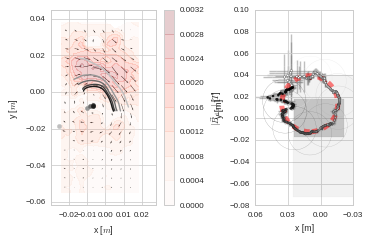

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(6.5,3.5))

gyration_path(points=points_average, errors=points_std, errorevery=1,
              circle_fit=True, xlim=(-0.03, 0.06), circles=True, 
              xticks=[-0.03, 0.0, 0.03, 0.06], axes=axes[1])

magnitude = np.sqrt(b_fields[0][:, :]**2 + b_fields[0][:, :]**2)
axes[0].quiver(grid[0, :, :][::5, ::5], grid[1, :, :][::5, ::5],
b_fields[0][:, :][::5, ::5], b_fields[1][:, :][::5, ::5])
contour = axes[0].contourf(grid[0, :, :], grid[1, :, :],
magnitude, alpha=0.2, cmap='Reds')
cb = plt.colorbar(contour, ax=axes[0], 
                  label=r"$|\vec{B}_{\perp z}|$ [$T$]")

colors = np.linspace(0.75, 0.1, 5)
colors = [str(color) for color in colors]

for i in range(5):
    length = streamlines[i][:,0].size
    axes[0].plot(streamlines[i][:,0][:length/2], 
                 streamlines[i][:,1][:length/2], 
                 c=colors[i])
    axes[0].plot(streamlines[i][:,0][length/2:], 
                 streamlines[i][:,1][length/2:], 
                 c=colors[i])
    axes[0].scatter(center_points[i][0], 
                    center_points[i][1], 
                    color=colors[i])
axes[0].set_xlabel(r'x [$m$]')
axes[0].set_ylabel(r'y [$m$]')


#plt.scatter(field_null[0], field_null[1], c='black', s=30)
#circle = plt.Circle((p1[0], p1[1]), p1[2], fill=False)
#axes.add_artist(circle)
axes[0].set_aspect('equal')

# Recreate field null fitter

In [4]:
bx = bx_interpolator(grid[0][:, :], grid[1][:, :])
by = by_interpolator(grid[0][:, :], grid[1][:, :])

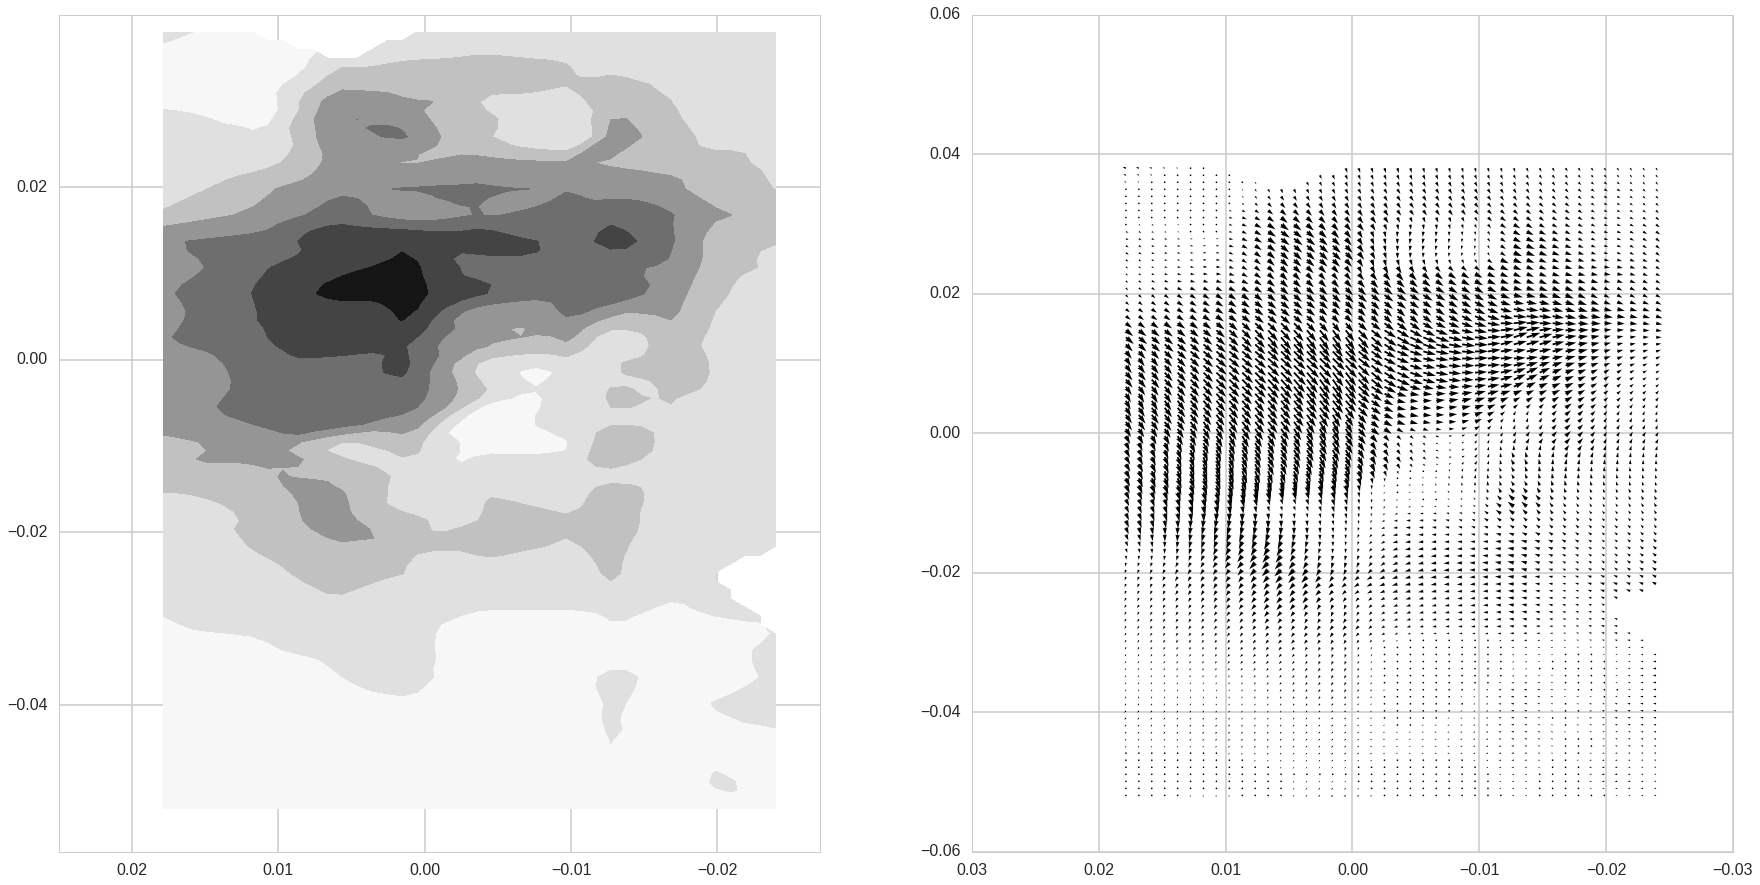

In [5]:
fig, axes = plt.subplots(1,2, figsize=(30, 15))
magnitude = np.sqrt(bx**2 + by**2)
axes[0].contourf(grid[0], grid[1], magnitude)
axes[1].quiver(grid[0], grid[1], bx, by)
axes[0].invert_xaxis()
axes[1].invert_xaxis()

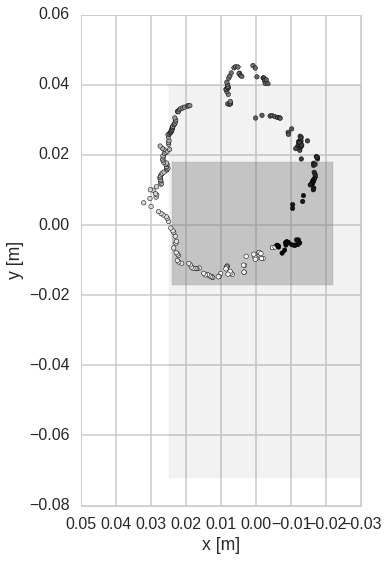

In [6]:
gyration_path(field_null_file='2017-04-12-10-09/field_nulls.txt')

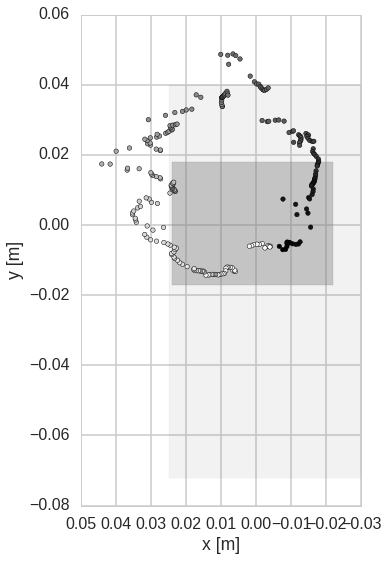

In [7]:
gyration_path(field_null_file='2017-04-17-18-49/field_nulls.txt')

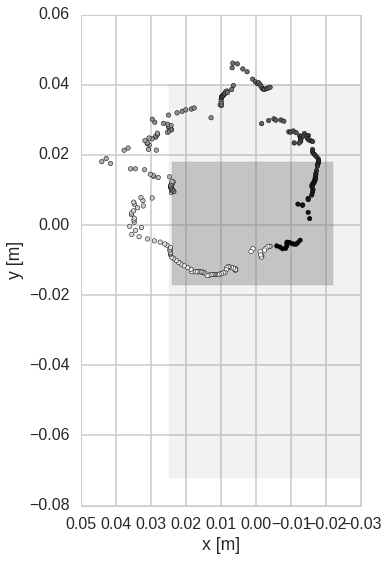

In [8]:
gyration_path(field_null_file='2017-04-17-19-00/field_nulls.txt')

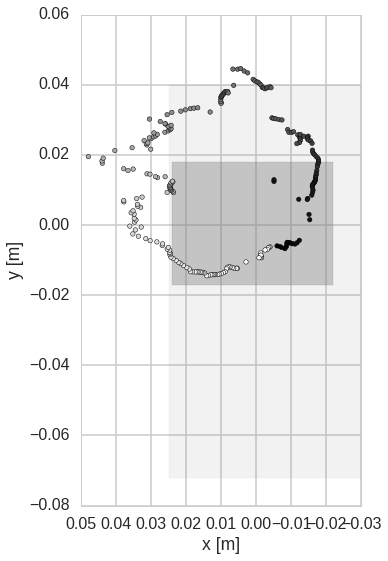

In [9]:
gyration_path(field_null_file='2017-04-17-19-12/field_nulls.txt')

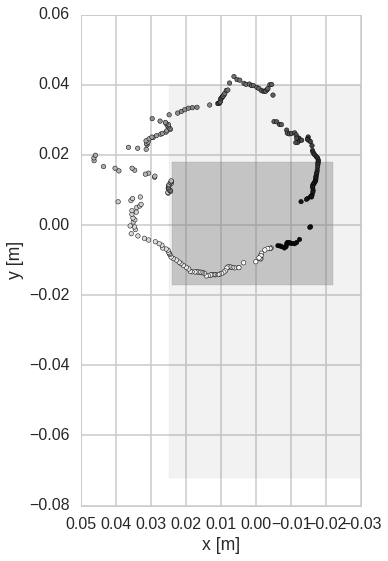

In [10]:
gyration_path(field_null_file='2017-04-17-19-22/field_nulls.txt')

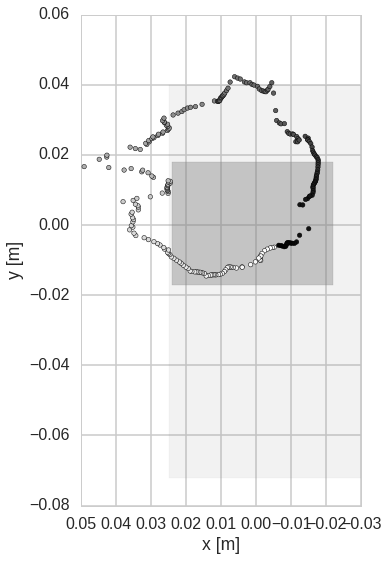

In [11]:
gyration_path(field_null_file='2017-04-17-19-42/field_nulls.txt')

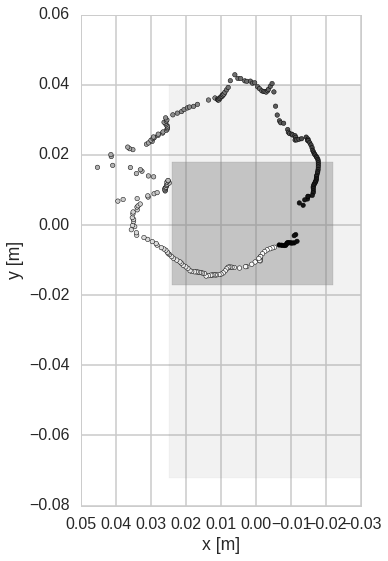

In [12]:
gyration_path(field_null_file='2017-04-17-19-48/field_nulls.txt')

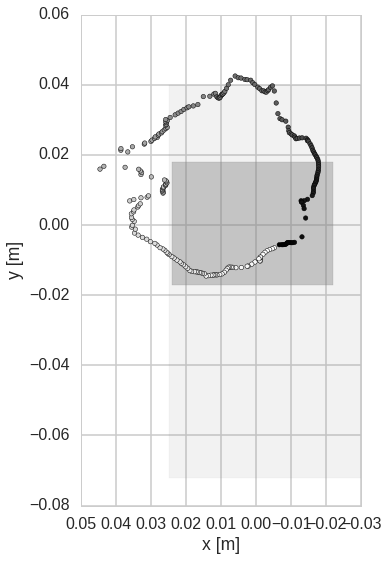

In [13]:
gyration_path(field_null_file='2017-04-17-19-56/field_nulls.txt')

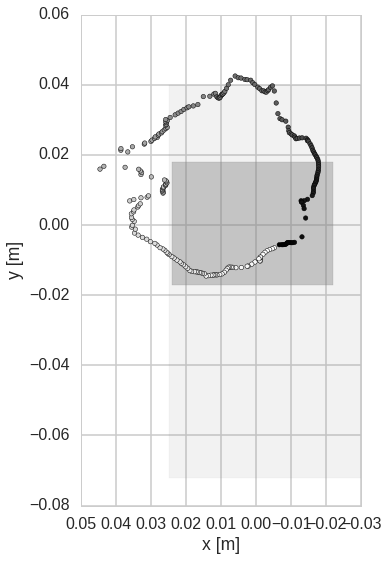

In [14]:
gyration_path(field_null_file='2017-04-17-19-56/field_nulls.txt')

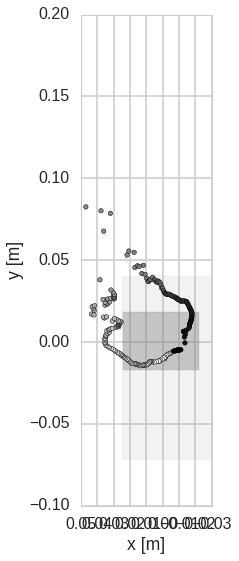

In [15]:
gyration_path(field_null_file='2017-04-17-20-04/field_nulls.txt')

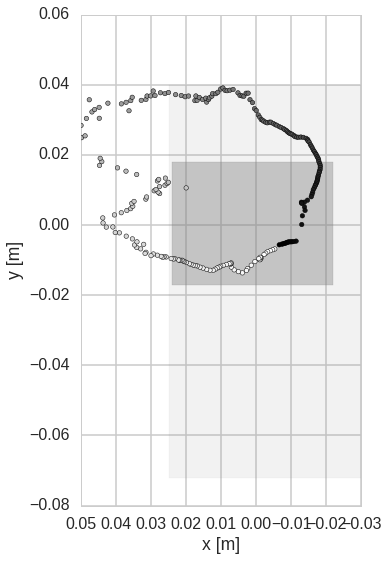

In [16]:
gyration_path(field_null_file='2017-04-17-20-09/field_nulls.txt')

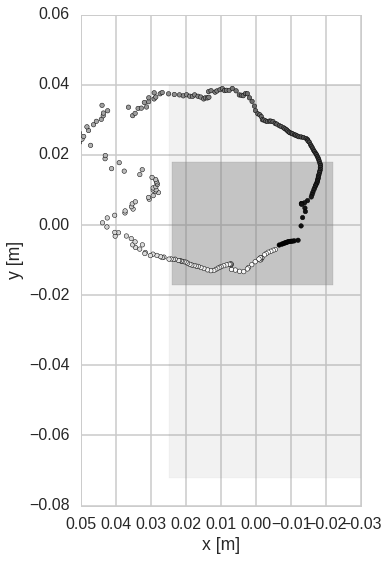

In [17]:
gyration_path(field_null_file='2017-04-17-20-14/field_nulls.txt')

In [21]:
field_null_directory = '/home/jensv/rsx/jens_analysis/output/field_nulls/' 
field_null_timestamps = ('2017-04-12-10-09',
                         '2017-04-17-18-49',
                         '2017-04-17-19-00',
                         '2017-04-17-19-12',
                         '2017-04-17-19-22',
                         '2017-04-17-19-42',
                         '2017-04-17-19-48', 
                         '2017-04-17-19-56',
                         '2017-04-17-20-04',
                         '2017-04-17-20-09',
                         '2017-04-17-20-14')
field_null_file = '/field_nulls.txt'

timestamp = field_null_timestamps[0]
field_null_path = field_null_directory + timestamp + field_null_file
points = np.loadtxt(field_null_path)[:, :, np.newaxis]

for timestamp in field_null_timestamps[1:-1]:
    field_null_path = field_null_directory + timestamp + field_null_file
    points = np.append(points, np.loadtxt(field_null_path)[:, :, np.newaxis],
                       axis=2)
points_average = np.mean(points, axis=2)
points_std = np.std(points, axis=2, ddof=1)
    

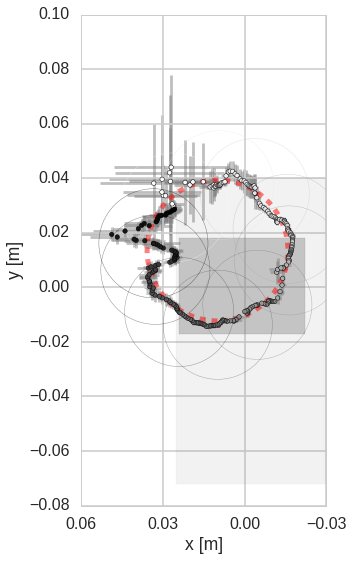

In [22]:
gyration_path(points=points_average, errors=points_std, errorevery=1,
              circle_fit=True, xlim=(-0.03, 0.06), circles=True, 
              xticks=[-0.03, 0.0, 0.03, 0.06])

In [23]:
measurement_limits = (-0.022, 0.024, -0.017, 0.018)
bxby_limits = (-0.032, 0.025, -0.072, 0.040)

points_average = np.roll(points_average, 125, axis=0)

measurement_in = np.logical_and(np.logical_and(measurement_limits[0] < points_average[:, 0],
                                points_average[:, 0] < measurement_limits[1]),
                 np.logical_and(measurement_limits[2] < points_average[:, 1],
                                points_average[:, 1] < measurement_limits[3]))
bxby_in = np.logical_and(np.logical_and(bxby_limits[0] < points_average[:, 0],
                                        points_average[:, 0] < bxby_limits[1]),
                         np.logical_and(bxby_limits[2] < points_average[:, 1],
                                        points_average[:, 1] < bxby_limits[3]))

In [24]:
measurement_in

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [25]:
bxby_in

array([False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [28]:
np.arange(0, 250*0.068, 0.068)[measurement_in]

array([  5.644,   5.712,   5.78 ,   5.848,   5.916,   5.984,   6.052,
         6.12 ,   6.188,   6.256,   6.324,   6.392,   6.46 ,   6.528,
         6.596,   6.664,   6.732,   6.8  ,   6.868,   6.936,   7.004,
         7.072,   7.14 ,   7.208,   7.276,   7.344,   7.412,   7.48 ,
         7.548,   7.616,   7.684,   7.752,   7.82 ,   7.888,   7.956,
         8.024,   8.092,   8.16 ,   8.228,   8.296,   8.364,   8.432,
         8.5  ,   8.568,   8.636,   8.704,   8.772,   8.84 ,   8.908,
         8.976,   9.044,   9.112,   9.18 ,   9.248,   9.316,   9.384,
         9.452,   9.52 ,   9.588,   9.656,   9.724,   9.792,   9.86 ,
         9.928,   9.996,  10.064,  10.132,  10.2  ,  10.268,  10.336,
        10.404,  10.472,  10.54 ,  10.608,  10.676,  10.744,  10.812,
        10.88 ,  10.948,  11.016,  11.084,  11.152,  11.22 ,  11.288,
        11.356,  11.424,  11.492,  11.56 ,  11.628,  11.696,  11.764,
        11.832,  11.9  ])

In [29]:
np.arange(0, 250*0.068, 0.068)[bxby_in]

array([  0.748,   0.816,   0.884,   0.952,   1.02 ,   1.088,   1.156,
         1.224,   1.292,   1.36 ,   1.428,   1.496,   1.564,   1.632,
         1.7  ,   1.768,   1.836,   1.904,   1.972,   2.04 ,   2.108,
         2.584,   2.652,   2.72 ,   2.788,   2.856,   2.924,   2.992,
         3.06 ,   3.128,   3.196,   3.264,   3.332,   3.4  ,   3.468,
         3.536,   3.604,   3.672,   3.74 ,   3.808,   3.876,   3.944,
         4.012,   4.08 ,   4.148,   4.216,   4.284,   4.352,   4.42 ,
         4.488,   4.556,   4.624,   4.692,   4.76 ,   4.828,   4.896,
         4.964,   5.032,   5.1  ,   5.168,   5.236,   5.304,   5.372,
         5.44 ,   5.508,   5.576,   5.644,   5.712,   5.78 ,   5.848,
         5.916,   5.984,   6.052,   6.12 ,   6.188,   6.256,   6.324,
         6.392,   6.46 ,   6.528,   6.596,   6.664,   6.732,   6.8  ,
         6.868,   6.936,   7.004,   7.072,   7.14 ,   7.208,   7.276,
         7.344,   7.412,   7.48 ,   7.548,   7.616,   7.684,   7.752,
         7.82 ,   7.